# COGS 108 - Final Project

# Overview
In this analysis we analyzed Glassdoor company reviews. We visualized our numerical rating data attain basic understanding of companies. Then, we parsed through the written reviews to understand the words that ascribe sentiment to the companies. Finally, we tested three weighting methods based off of date of review and helpful count to develop a scoring metric for the companies. 

# Names 
- Xinyi He 
- Isabel Suizo 
- Stanley Tan 
- Benson Wu 
- Philip Zeng 


# Group Members IDs
- A13561164
- A15485717
- A12925571
- A13171365
- A13051974

# Research Question 
How can understanding the sentiment of company reviews help us decide and rank which tech company is the best to work for and what aspects of these “best” companies do people enjoy? 


# Background and Prior Work
Facebook, Apple, Amazon, Netflix, Microsoft, and Google are a collection of high-performing tech giants that have much influence on today’s market. For many college students, working at these top-tier companies might seem like a dream due to their pay, impact on the technology industry, and fast paced atmosphere. However, what most students might not see at face value when considering these companies is what really goes on internally at these companies with their employees. Gloria Liu, author of This is Sillicon Valley on Medium, describes the feeling of “becoming part of the machine” while working at Google in Silicon Valley and ultimately decided to leave Silicon Valley to escape the toxic culture of the Silicon Valley. But surely, not everyone must feel like this. 

The only existing work on this dataset comes from Michal Bogacz. He created a kernel on Kaggle that analyzes pros and cons based off of character length and most common words from the “pros” and “cons” of the data set. 

#### References
https://onezero.medium.com/this-is-silicon-valley-3c4583d6e7c2
https://www.kaggle.com/michau96/which-corporation-is-worth-working-for


# Hypothesis
We hypothesize that companies’ whose reviews for the “Pros” section will contain more “positive” words and being able to quantify this data will provide us with a better idea of how “good” a company is beyond the numeric ratings that are given.

# Dataset
- Dataset Name: Employee Reviews
- Note: The dataset that we are using is from Peter Sunga’s Kaggle page. The data set was deleted in the middle of this creating this project. However, we downloaded the dataset beforehand in order to still have access to it. 
- Link to the dataset: https://www.kaggle.com/petersunga/google-amazon-facebook-employee-reviews/kernels
- This data is scraped off of Glassdoor, a popular website where former and current employees can submit reviews for companies. The dataset contains more than 67,529 observations, and 16 features in numerical and text form such as the company name, overall-ratings, pros, cons, ratings of various measures such as work/life balance and culture/values. We are going to create models to search for meaningful trends within this dataset in order to help us answer our question and verify our hypothesis.




# Setup

In [42]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
import math
import nltk
from wordcloud import WordCloud, STOPWORDS 

# Configure libaries
# Seaborn library
sns.set()
sns.set_context('talk')


# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

# Set palette to colorblind
palette = sns.color_palette("colorblind")
sns.set_palette(palette)

# Data Cleaning
The dataset that is used for this analysis did not require any intense cleaning to make the data useable. However, some of the numerical values were stored incorrectly as objects and had to be converted to floats. 

In [43]:
#Read in data
df = pd.read_csv("employee_reviews.csv")

#Preview of data
df.head()

,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
0,1,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,none,5.0,4.0,5.0,5.0,4.0,5.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
1,2,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,4.0,2.0,3.0,3.0,5.0,3.0,2094,https://www.glassdoor.com/Reviews/Google-Revie...
2,3,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,5.0,4.0,5.0,5.0,4.0,949,https://www.glassdoor.com/Reviews/Google-Revie...
3,4,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5.0,2.0,5.0,5.0,4.0,5.0,498,https://www.glassdoor.com/Reviews/Google-Revie...
4,5,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5.0,5.0,5.0,5.0,5.0,5.0,49,https://www.glassdoor.com/Reviews/Google-Revie...


In [44]:
#Convert rating variables from objects to float64's
ratinglist = ['work-balance-stars','culture-values-stars', 'carrer-opportunities-stars', 'comp-benefit-stars', 'senior-mangemnet-stars']
for rating in ratinglist:
    df[rating] = df[rating].apply(pd.to_numeric, downcast='float', errors='coerce')


# Data Analysis & Results

## Visualization 

This section breaks down the distribution of ratings of each company across several categories based on a five-star rating scale. For each company, the general rating in each of the following categories: overall, work balance, culture values, career opportunities, benefits and senior management are depicted using a box plots. These boxplots indicate the distribution of the five-star ratings by indicating the median rating, first and third quartile of the distribution, and the range. 

In [45]:
df_ratings = df[['overall-ratings','work-balance-stars','culture-values-stars','carrer-opportunities-stars','comp-benefit-stars','senior-mangemnet-stars']]
df_ratings.head()

,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars
0,5.0,4.0,5.0,5.0,4.0,5.0
1,4.0,2.0,3.0,3.0,5.0,3.0
2,5.0,5.0,4.0,5.0,5.0,4.0
3,5.0,2.0,5.0,5.0,4.0,5.0
4,5.0,5.0,5.0,5.0,5.0,5.0


In [46]:
#Rename columns
cols = ['overall-ratings', 'work-balance-stars', 'culture-values-stars',
       'carrer-opportunities-stars', 'comp-benefit-stars',
       'senior-mangemnet-stars']
df_ratings.columns = ['overall', 'work balance', 'culture values', 'career opportunities', 'benefits', 'senior management']

#### Let's show the distribution of all the ratings first

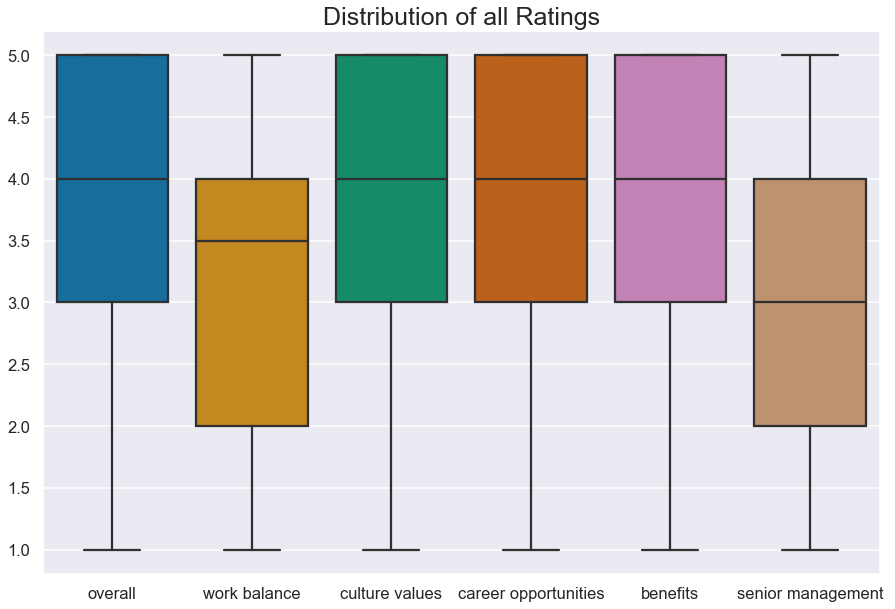

In [47]:
plt.figure(figsize=(15,10))
#plt.xticks(rotation=45)
overall = sns.boxplot(data=df_ratings)
overall.set_title('Distribution of all Ratings', fontsize=25);

#### Now, let's show the distribution of these ratings across the different companies

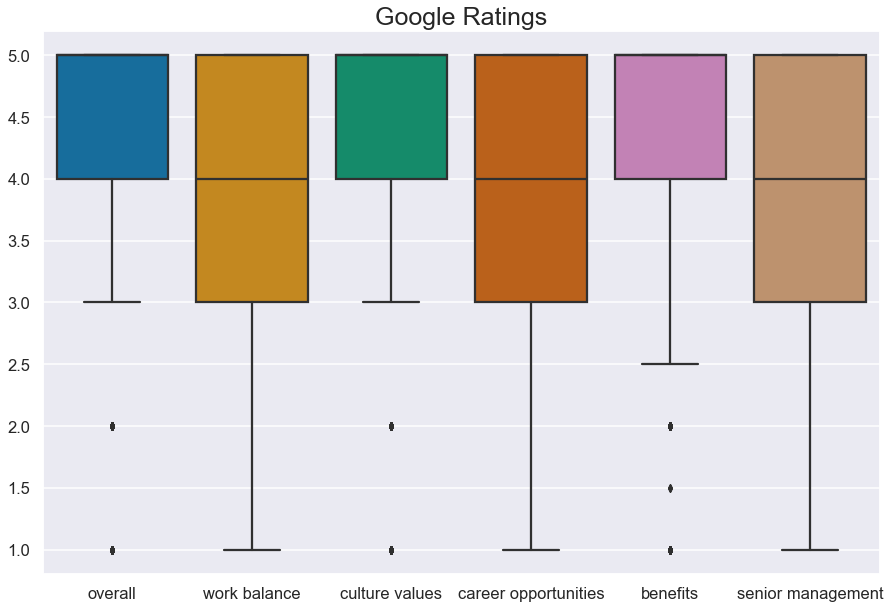

In [61]:
#Google
df_google = df[df['company'] == 'google']
df_google = df_google[['overall-ratings','work-balance-stars','culture-values-stars','carrer-opportunities-stars','comp-benefit-stars','senior-mangemnet-stars']]
df_google.columns
cols = ['overall-ratings', 'work-balance-stars', 'culture-values-stars',
       'carrer-opportunities-stars', 'comp-benefit-stars',
       'senior-mangemnet-stars']
df_google.columns = ['overall', 'work balance', 'culture values', 'career opportunities', 'benefits', 'senior management']
plt.figure(figsize=(15,10))
#plt.xticks(rotation=45)
google = sns.boxplot(data=df_google)
google.set_title('Google Ratings', fontsize=25);

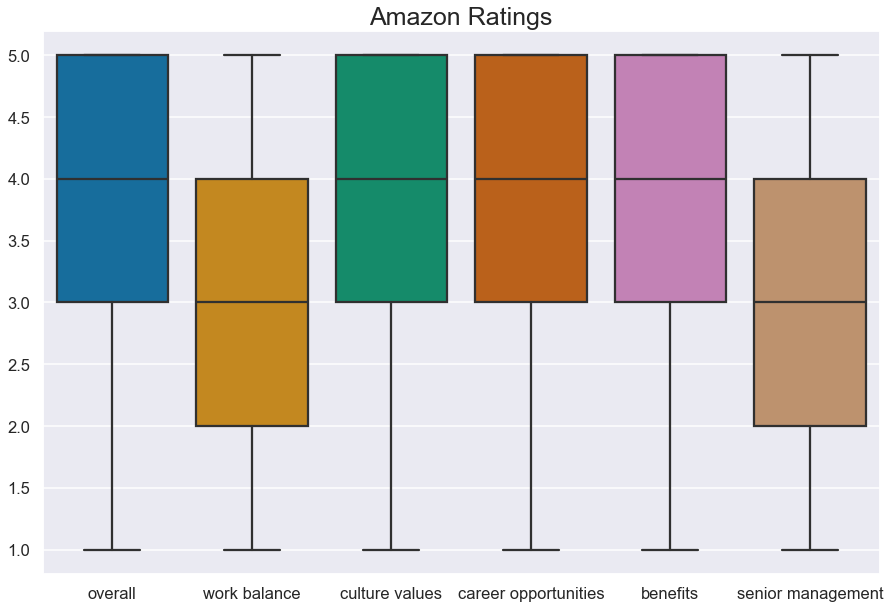

In [65]:
#Amazon
df_amazon = df[df['company'] == 'amazon']
df_amazon = df_amazon[['overall-ratings','work-balance-stars','culture-values-stars','carrer-opportunities-stars','comp-benefit-stars','senior-mangemnet-stars']]
df_amazon.columns
cols = ['overall-ratings', 'work-balance-stars', 'culture-values-stars',
       'carrer-opportunities-stars', 'comp-benefit-stars',
       'senior-mangemnet-stars']
df_amazon[cols]=df_amazon.apply(pd.to_numeric, errors='coerce', axis=1)
df_amazon.columns = ['overall', 'work balance', 'culture values', 'career opportunities', 'benefits', 'senior management']
plt.figure(figsize=(15,10))
#plt.xticks(rotation=45)
amazon = sns.boxplot(data=df_amazon)
amazon.set_title('Amazon Ratings', fontsize=25);

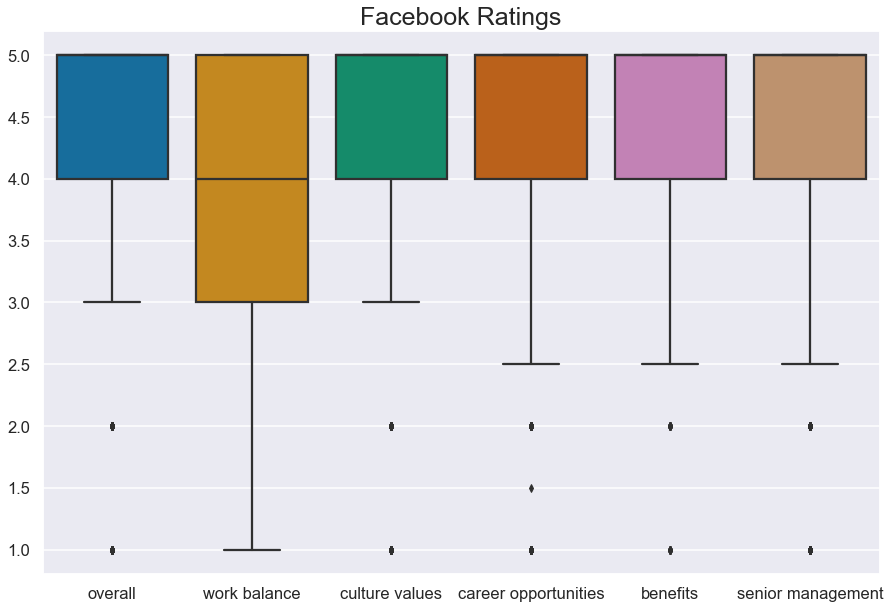

In [68]:
#Facebook
df_facebook = df[df['company'] == 'facebook']
df_facebook = df_facebook[['overall-ratings','work-balance-stars','culture-values-stars','carrer-opportunities-stars','comp-benefit-stars','senior-mangemnet-stars']]
df_facebook.columns
cols = ['overall-ratings', 'work-balance-stars', 'culture-values-stars',
       'carrer-opportunities-stars', 'comp-benefit-stars',
       'senior-mangemnet-stars']
df_facebook[cols]=df_facebook.apply(pd.to_numeric, errors='coerce', axis=1)
df_facebook.columns = ['overall', 'work balance', 'culture values', 'career opportunities', 'benefits', 'senior management']
plt.figure(figsize=(15,10))
#plt.xticks(rotation=90)
facebook = sns.boxplot(data=df_facebook)
facebook.set_title('Facebook Ratings', fontsize=25);

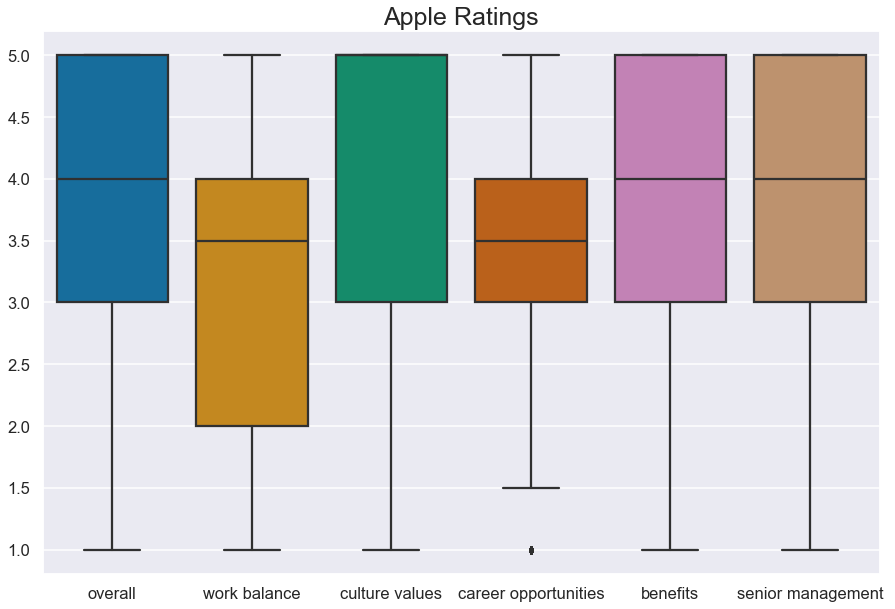

In [71]:
#Apple
df_apple = df[df['company'] == 'apple']
df_apple = df_apple[['overall-ratings','work-balance-stars','culture-values-stars','carrer-opportunities-stars','comp-benefit-stars','senior-mangemnet-stars']]
cols = ['overall-ratings', 'work-balance-stars', 'culture-values-stars',
       'carrer-opportunities-stars', 'comp-benefit-stars',
       'senior-mangemnet-stars']
df_apple[cols]=df_apple.apply(pd.to_numeric, errors='coerce', axis=1)
df_apple.columns = ['overall', 'work balance', 'culture values', 'career opportunities', 'benefits', 'senior management']
plt.figure(figsize=(15,10))
#plt.xticks(rotation=90)
apple = sns.boxplot(data=df_apple)
apple.set_title('Apple Ratings', fontsize=25);

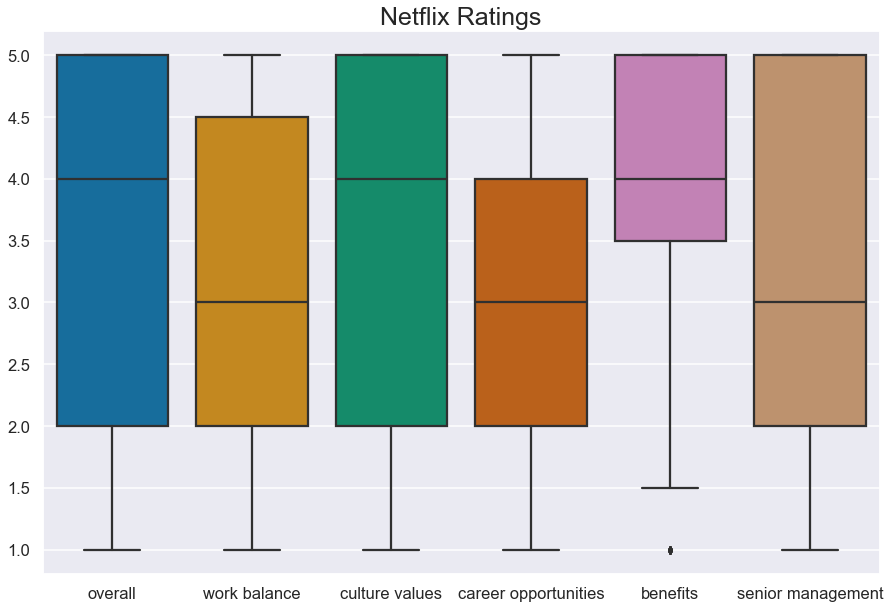

In [74]:
#Netflix
df_netflix = df[df['company'] == 'netflix']
df_netflix = df_netflix[['overall-ratings','work-balance-stars','culture-values-stars','carrer-opportunities-stars','comp-benefit-stars','senior-mangemnet-stars']]
cols = ['overall-ratings', 'work-balance-stars', 'culture-values-stars',
       'carrer-opportunities-stars', 'comp-benefit-stars',
       'senior-mangemnet-stars']
df_netflix[cols]=df_netflix.apply(pd.to_numeric, errors='coerce', axis=1)
df_netflix.columns = ['overall', 'work balance', 'culture values', 'career opportunities', 'benefits', 'senior management']
plt.figure(figsize=(15,10))
#plt.xticks(rotation=90)
netflix = sns.boxplot(data=df_netflix)
netflix.set_title('Netflix Ratings', fontsize=25);

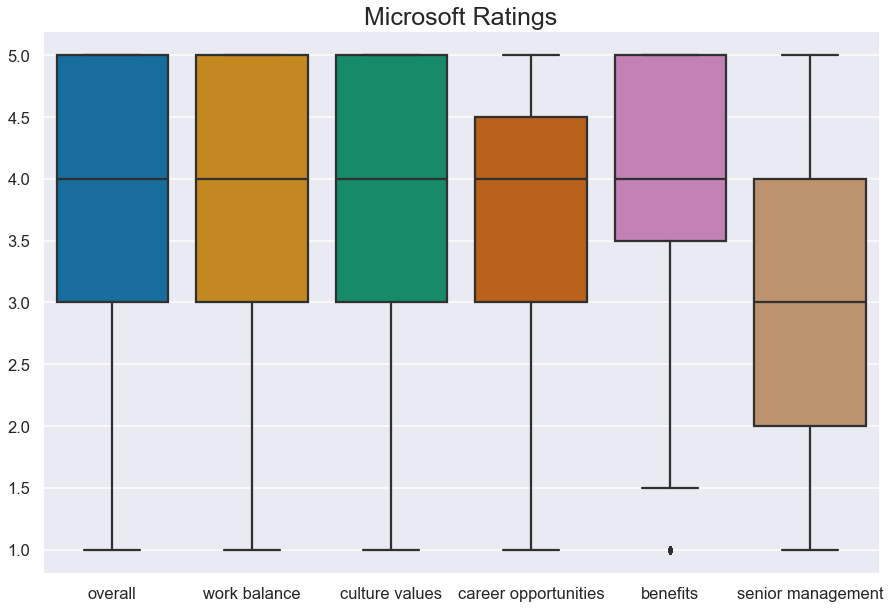

In [78]:
#Microsoft
df_microsoft = df[df['company'] == 'microsoft']
df_microsoft = df_microsoft[['overall-ratings','work-balance-stars','culture-values-stars','carrer-opportunities-stars','comp-benefit-stars','senior-mangemnet-stars']]
df_microsoft.columns
cols = ['overall-ratings', 'work-balance-stars', 'culture-values-stars',
       'carrer-opportunities-stars', 'comp-benefit-stars',
       'senior-mangemnet-stars']
df_microsoft[cols]=df_microsoft.apply(pd.to_numeric, errors='coerce', axis=1)
df_microsoft.columns = ['overall', 'work balance', 'culture values', 'career opportunities', 'benefits', 'senior management']
plt.figure(figsize=(15,10))
#plt.xticks(rotation=90)
microsoft = sns.boxplot(data=df_microsoft)
microsoft.set_title('Microsoft Ratings', fontsize=25);

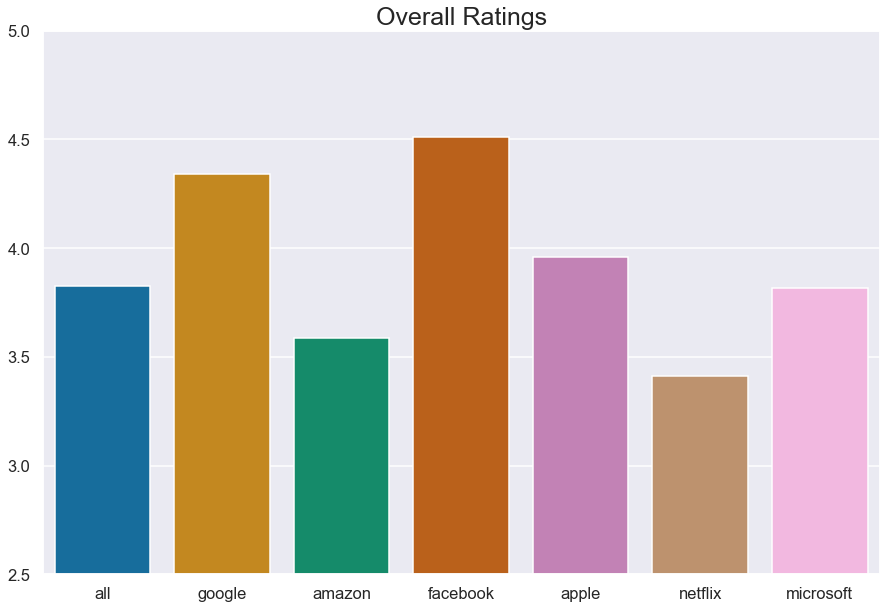

In [82]:
overall_set = {}
overall_set["all"] = df_ratings['overall'].mean()
overall_set["google"] = df_google['overall'].mean()
overall_set["amazon"] = df_amazon['overall'].mean()
overall_set["facebook"] = df_facebook['overall'].mean()
overall_set["apple"] = df_apple['overall'].mean()
overall_set["netflix"] = df_netflix['overall'].mean()
overall_set["microsoft"] = df_microsoft['overall'].mean()
df_overall = pd.DataFrame.from_dict(overall_set, orient='index')
df_overall.columns = ['average rating']
df_overall = df_overall.T
plt.figure(figsize=(15,10))
overall = sns.barplot(data=df_overall)
overall.set_title('Average Overall Ratings', fontsize=25)
overall.set(ylim=(2.5,5));




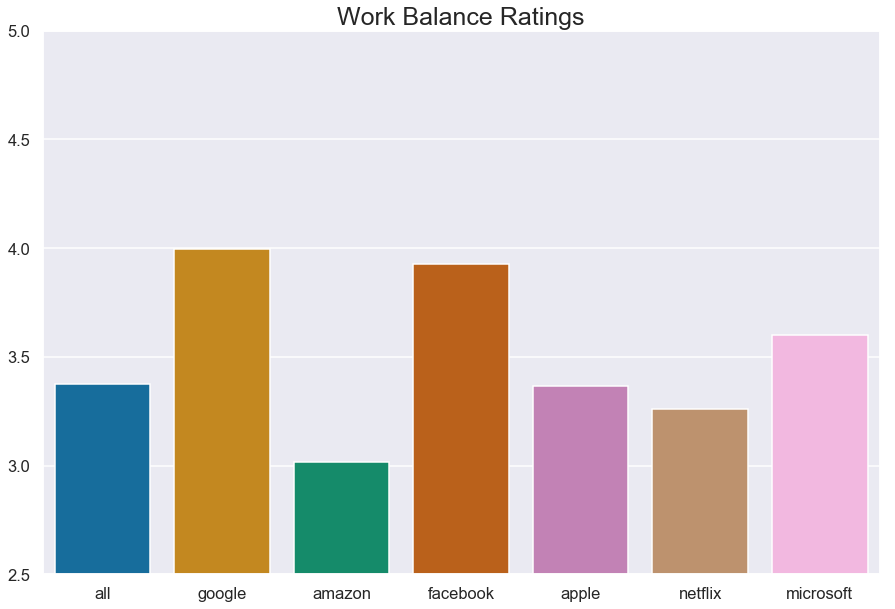

In [85]:
workbalance_set = {}
workbalance_set["all"] = df_ratings['work balance'].mean()
workbalance_set["google"] = df_google['work balance'].mean()
workbalance_set["amazon"] = df_amazon['work balance'].mean()
workbalance_set["facebook"] = df_facebook['work balance'].mean()
workbalance_set["apple"] = df_apple['work balance'].mean()
workbalance_set["netflix"] = df_netflix['work balance'].mean()
workbalance_set["microsoft"] = df_microsoft['work balance'].mean()
df_workbalance = pd.DataFrame.from_dict(workbalance_set, orient='index')
df_workbalance.columns = ['work balance rating']
df_workbalance = df_workbalance.T
plt.figure(figsize=(15,10))
workbalance = sns.barplot(data=df_workbalance)
workbalance.set_title('Average Work Balance Ratings', fontsize=25)
workbalance.set(ylim=(2.5,5));

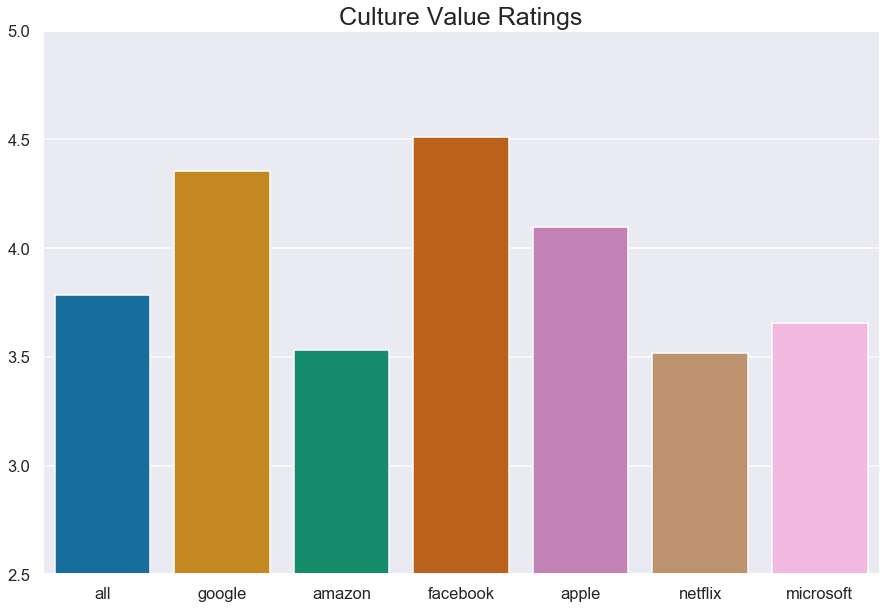

In [96]:
culturevalues_set = {}
culturevalues_set["all"] = df_ratings['culture values'].mean()
culturevalues_set["google"] = df_google['culture values'].mean()
culturevalues_set["amazon"] = df_amazon['culture values'].mean()
culturevalues_set["facebook"] = df_facebook['culture values'].mean()
culturevalues_set["apple"] = df_apple['culture values'].mean()
culturevalues_set["netflix"] = df_netflix['culture values'].mean()
culturevalues_set["microsoft"] = df_microsoft['culture values'].mean()
df_culturevalues = pd.DataFrame.from_dict(culturevalues_set, orient='index')
df_culturevalues.columns = ['culture values rating']
df_culturevalues = df_culturevalues.T
plt.figure(figsize=(15,10))
culturevalues = sns.barplot(data=df_culturevalues)
culturevalues.set_title('Average Culture Value Ratings', fontsize=25)
culturevalues.set(ylim=(2.5,5));

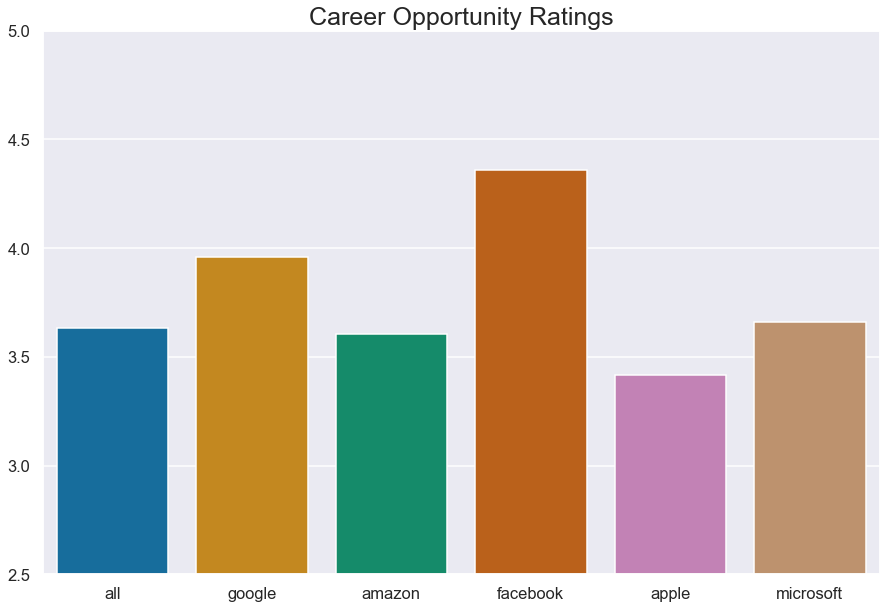

In [91]:
caropps_set = {}
caropps_set["all"] = df_ratings['career opportunities'].mean()
caropps_set["google"] = df_google['career opportunities'].mean()
caropps_set["amazon"] = df_amazon['career opportunities'].mean()
caropps_set["facebook"] = df_facebook['career opportunities'].mean()
caropps_set["apple"] = df_apple['career opportunities'].mean()
caropps_set["netflix"] = df_netflix['career opportunities'].mean()
caropps_set["microsoft"] = df_microsoft['career opportunities'].mean()
df_caropps = pd.DataFrame.from_dict(caropps_set, orient='index')
df_caropps.columns = ['career opportunities rating']
df_caropps = df_caropps.T
plt.figure(figsize=(15,10))
caropps = sns.barplot(data=df_caropps)
caropps.set_title('Average Career Opportunity Ratings', fontsize=25)
caropps.set(ylim=(2.5,5));

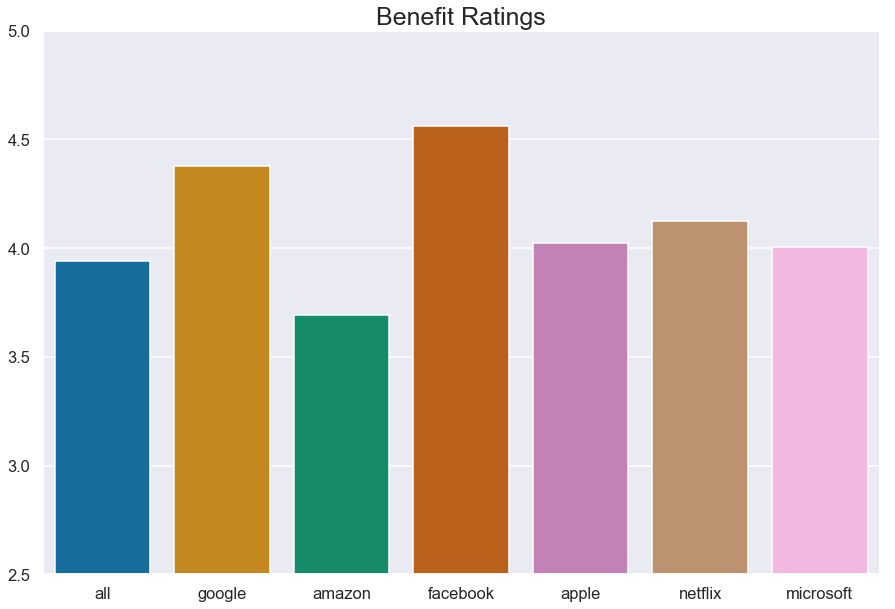

In [95]:
benefits_set = {}
benefits_set["all"] = df_ratings['benefits'].mean()
benefits_set["google"] = df_google['benefits'].mean()
benefits_set["amazon"] = df_amazon['benefits'].mean()
benefits_set["facebook"] = df_facebook['benefits'].mean()
benefits_set["apple"] = df_apple['benefits'].mean()
benefits_set["netflix"] = df_netflix['benefits'].mean()
benefits_set["microsoft"] = df_microsoft['benefits'].mean()
df_benefits= pd.DataFrame.from_dict(benefits_set, orient='index')
df_benefits.columns = ['benefits rating']
df_benefits = df_benefits.T
plt.figure(figsize=(15,10))
benefits = sns.barplot(data=df_benefits)
benefits.set_title('Average Benefit Ratings', fontsize=25)
benefits.set(ylim=(2.5,5));

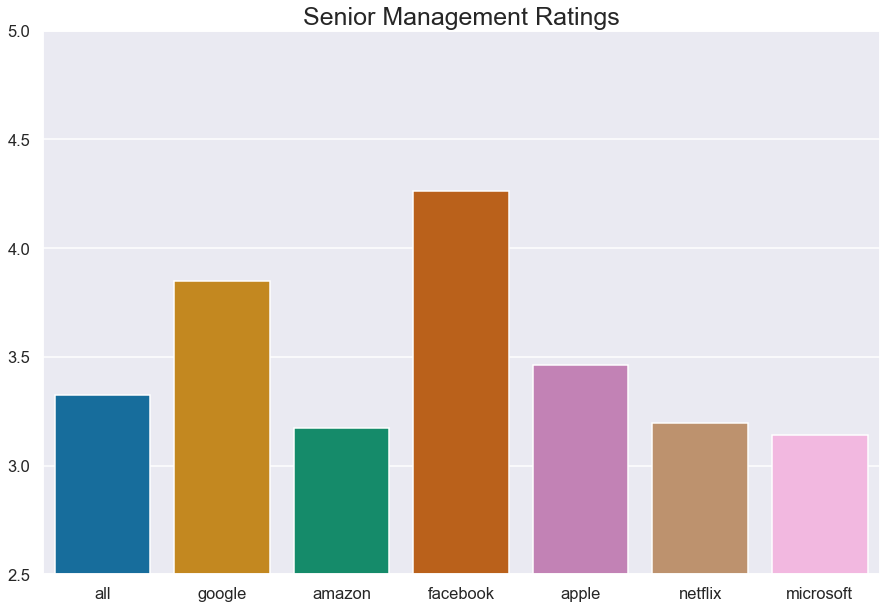

In [100]:
snrmgmt_set = {}
snrmgmt_set["all"] = df_ratings['senior management'].mean()
snrmgmt_set["google"] = df_google['senior management'].mean()
snrmgmt_set["amazon"] = df_amazon['senior management'].mean()
snrmgmt_set["facebook"] = df_facebook['senior management'].mean()
snrmgmt_set["apple"] = df_apple['senior management'].mean()
snrmgmt_set["netflix"] = df_netflix['senior management'].mean()
snrmgmt_set["microsoft"] = df_microsoft['senior management'].mean()
df_snrmgmt= pd.DataFrame.from_dict(snrmgmt_set, orient='index')
df_snrmgmt.columns = ['senior management rating']
df_snrmgmt = df_snrmgmt.T
plt.figure(figsize=(15,10))
snrmgmt = sns.barplot(data=df_snrmgmt)
snrmgmt.set_title('Average Senior Management Ratings', fontsize=25)
snrmgmt.set(ylim=(2.5,5));

By analyzing these graphs, it is evident that employers report the highest ratings for Facebook. Facebook’s boxplot highlights a tight distribution where more than 50% of ratings in the overall, culture values, career opportunities, benefits, and senior management are 5’s. 


On the other hand, it appears that Netflix not only has the greatest variability in rating, but also the lowest average ratings across all categories. Taking a look at Netflix’s distributions, 50% of its ratings in work balance, career opportunities, and senior management all lie below a 3. When we compare such results to the average distribution when taking into account all companies, we can see that Netflix is well below the average, noting that its median consistently lies below the average of all companies across each category. However, this is not enough to say that Netflix can be considered the “worst” among each of the companies since it also has the greatest spread of data. While the interquartile range(IQR) of boxplots for every other company across all categories spans one, sometimes two stars, the IQR of 3 of Netflix’s categories covers 3 stars. The IQR of Netflix’s overall category ranges from 2 to 5 with 50% of the data concentrated between 4 and 5. This spread covers almost all of the values in the range, which implies that there is great variability in the employees’ perception of the company. However, the concentration of the ratings in the upper quartile still shows that there is a majority of employees who have a positive view on Netflix. 


# Statistical Testing

After examining the distributions of ratings across different companies, we were interested in examining the difference in ratings between reviewers who were former employees versus reviewers who are current employees. We stratified the reviewers by former and current employees and plotted the distributions of overall ratings across the six companies by employment status. 



In [104]:
#Create a column that labels people as either former or current

#Current
condition = df['job-title'].str.contains(r'Current') == True
column_name = 'job-status'
df.loc[condition, column_name] = 'Current'

#Former
condition = df['job-title'].str.contains(r'Former') == True
column_name = 'job-status'
df.loc[condition, column_name] = 'Former'

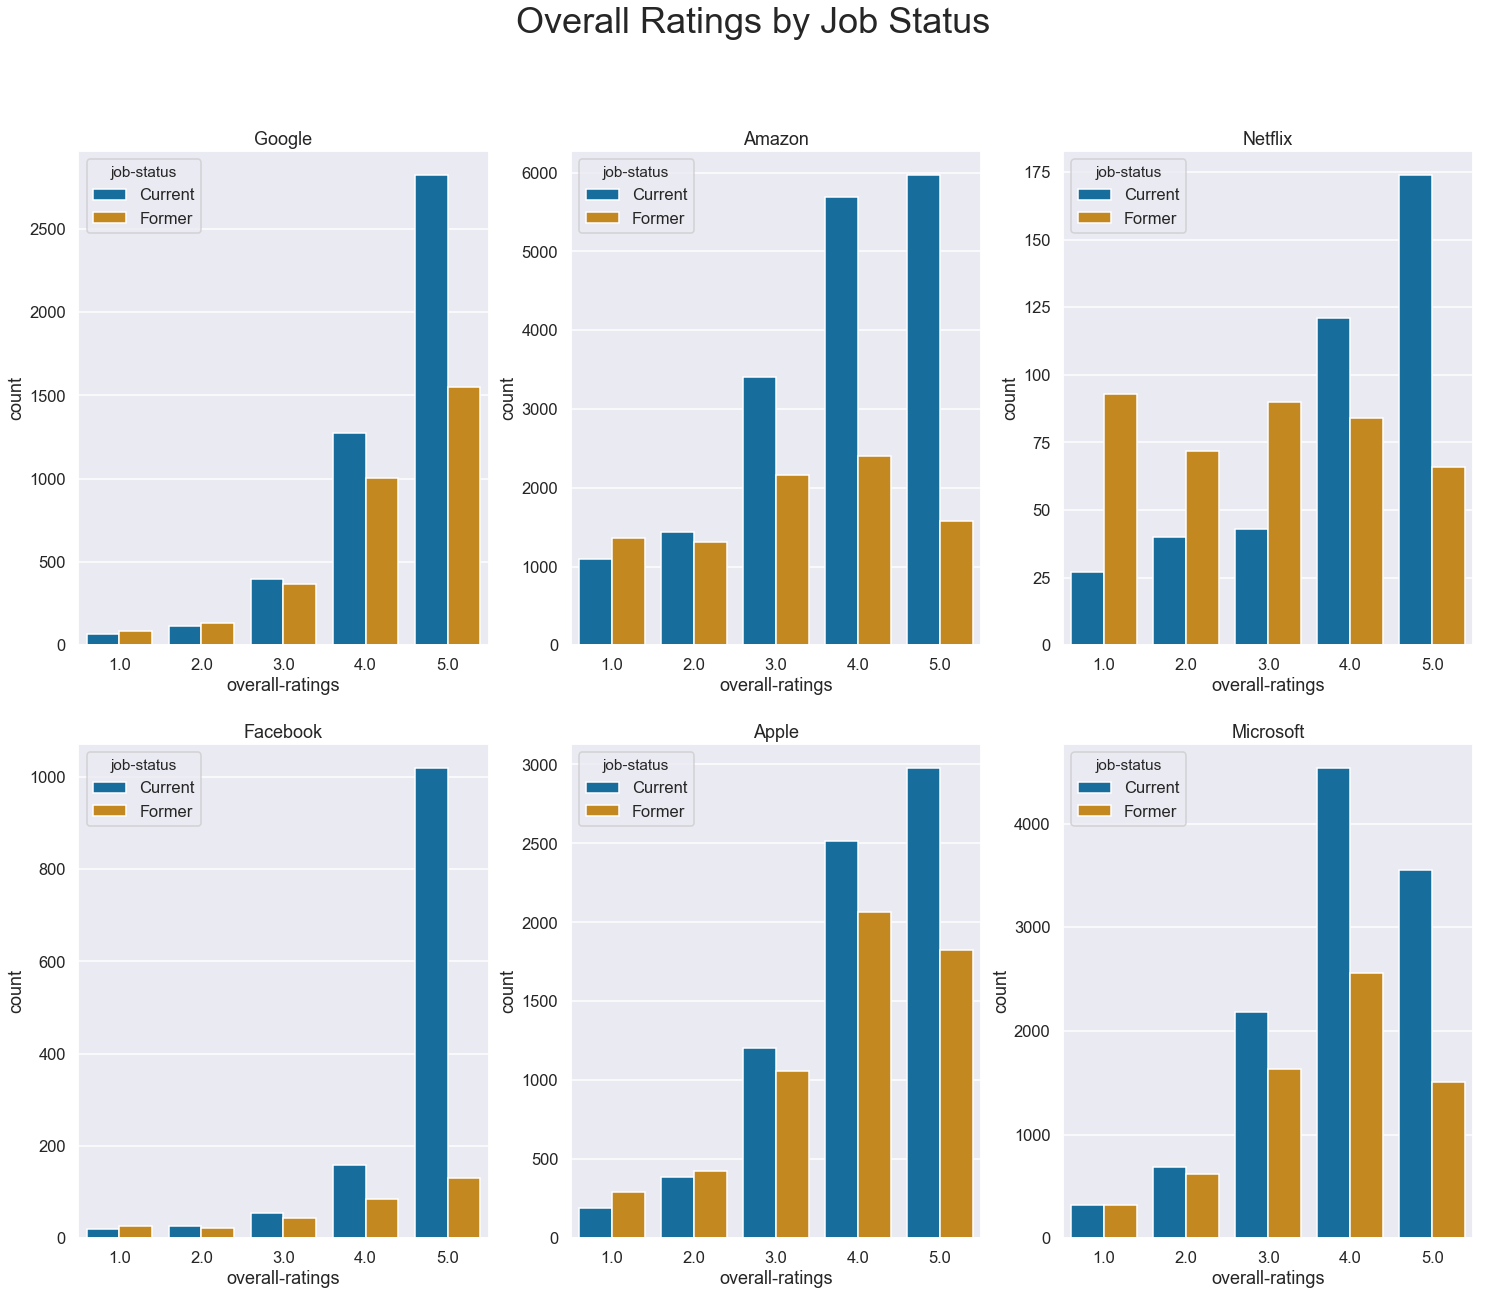

<Figure size 288x720 with 0 Axes>

In [136]:
#Let's plot the overall rating by job status 
#https://stackoverflow.com/questions/48204780/how-to-plot-multiple-figures-in-a-row-using-seaborn
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(25,20))
fig.suptitle('Overall Ratings by Job Status', fontsize=36)
plt.figure(figsize=(4,10))
sns.countplot(x='overall-ratings', hue='job-status', data=df[df['company']=='google'], ax=ax1).set_title('Google')
sns.countplot(x='overall-ratings', hue='job-status', data=df[df['company']=='amazon'], ax=ax2).set_title('Amazon')
sns.countplot(x='overall-ratings', hue='job-status', data=df[df['company']=='netflix'], ax=ax3).set_title('Netflix')
sns.countplot(x='overall-ratings', hue='job-status', data=df[df['company']=='facebook'], ax=ax4).set_title('Facebook')
sns.countplot(x='overall-ratings', hue='job-status', data=df[df['company']=='apple'], ax=ax5).set_title('Apple')
sns.countplot(x='overall-ratings', hue='job-status', data=df[df['company']=='microsoft'], ax=ax6).set_title('Microsoft');



At face value, we can see that there are a lot less former employees who submit reviews. We utilize a one-sided 2 Sample t-test at a 0.05 significance level to test for statistical differences in means ($\mu$) between former and current employees across all 6 companies for the various review criteria (Overall rating, work balance, culture values, career opportunities, compensation and benefits, and senior management). The following is the t statistic: $t = \frac{\bar X - \mu}{s / \sqrt{n}}$.

We tested the following hypothesis: 
$$H_0 : \mu_{rating, former} \;\; \geq \;\; \mu_{rating, current}$$
$$H_1 : \mu_{rating, former} \;\; < \;\; \mu_{rating, current}$$

such that $rating$ = {overall rating, work balance rating, culture values, career opportunities, compensation and benefits, and senior management}

We only output the tests that fail to reject the null.


In [120]:
ratinglist = ['overall-ratings','work-balance-stars','culture-values-stars', 'carrer-opportunities-stars', 'comp-benefit-stars', 'senior-mangemnet-stars']
for rating in ratinglist:
    for company in list(['google', 'amazon', 'facebook', 'netflix', 'apple', 'microsoft']):
       
        former = df[rating][(df['company']==company) & ( df['job-status']=='Former')].values
        current = df[rating][(df['company']==company) & ( df['job-status']=='Current')].values
        t_val, p_val = ttest_ind(former, current,nan_policy='omit')
        if p_val/2 < 0.05 and t_val <0:
            pass
        else:
            print('Fail to reject the null that the ', rating,'of former employees is greater or equal from current employees for', company)
            print("\n")

Fail to reject the null that the  comp-benefit-stars of former employees is greater or equal from current employees for microsoft




All but one of the tests (Compensation and benefit stars from former and current employees for Microsoft) reject the null hypothesis, so a majority of the average ratings from former employees are statistically less than the average ratings from current employees. 

This is an interesting result because it's clear that former employees tend to give lower ratings than former employees. From an outsider's perspective one might hypothesize that former employees leave lower reviews because of some negative experiences that they they might have encountered at work, because otherwise there is not that much incentive to leave a review after leaving a company. This leads us to analyze the text written in the "pros" and "cons" sections of the reviews.

# Analyzing text data in the reviews

The NLP part basically goes through the contents of the pros and cons part of each employee_review. For each company, we want to find out the top 3 most common pros words and the top 3 most common con words. However, some words like “a, an, for” are commonly used in sentences but they actually don’t provide any useful discriminative information. So we classify these words as stopwords and ignore them when encountering them in the process of finding the most common words. Also after the first time of finding the top 3 most common pros words and the top 3 most common con words, we found that some words like “work, company, people, get, working” are also very common and appear in both the top most common pros and cons words. Under such circumstances, they are not useful for discriminating information so that we also want to include them as stopwords. After this, we run through all the reviews and get the top 3 most common pros words and con words. Also, we use wordplot to plot the top 15 most common pros words and top 15 most common con words for each company as it is better to visualize.



In [138]:
company = list(df['company'].value_counts().keys())
company


['amazon', 'microsoft', 'apple', 'google', 'facebook', 'netflix']

In [139]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop = list(stop)+["work","company","people","get","working"]

In [141]:
def common(company, n, s):
    dict1 = dict()
    for line in df[df['company'] == company][s]:
        for word in line.split():
            word  = word.lower()
            if word in stop or word == "-" or word == company:
                continue
            if (word not in dict1):
                dict1[word] = 0
            dict1[word] += 1
    list1 = sorted([(dict1[i],i) for i in dict1],reverse = True)
    return [v for u,v in list1[:n]]

These are the top three words in "pros" for the six companies. 

In [144]:
for i in company:
    print(i, common(i,3, "pros"))

amazon ['good', 'great', 'pay']
microsoft ['great', 'good', 'benefits']
apple ['great', 'good', 'benefits']
google ['great', 'good', 'smart']
facebook ['great', 'good', 'culture']
netflix ['great', 'good', 'free']


These are the top three words in "cons" for the six companies.

In [145]:
for i in company:
    print(i,common(i,3, "cons"))

amazon ['management', 'time', 'hours']
microsoft ['management', 'many', 'much']
apple ['management', 'retail', 'time']
google ['many', 'hard', 'big']
facebook ['really', 'hard', 'much']
netflix ['management', 'time', 'like']


In [146]:
def wordplot(n,s):
    fig,axe = plt.subplots(1,6,figsize=(25, 5))
    fig.suptitle(s, fontsize=24)
    for i in range(6):
        comment_words = ''
        for w in common(company[i],n,s):
            comment_words += w + " "
        comment_words

        wordcloud = WordCloud(width = 800, height = 800, 
                        background_color ='white', 
                        min_font_size = 10).generate(comment_words) 

        # plot the WordCloud image                        
        axe[i].imshow(wordcloud) 
        axe[i].axis("off") 
        axe[i].set_title(company[i])


        axe[i].plot() 

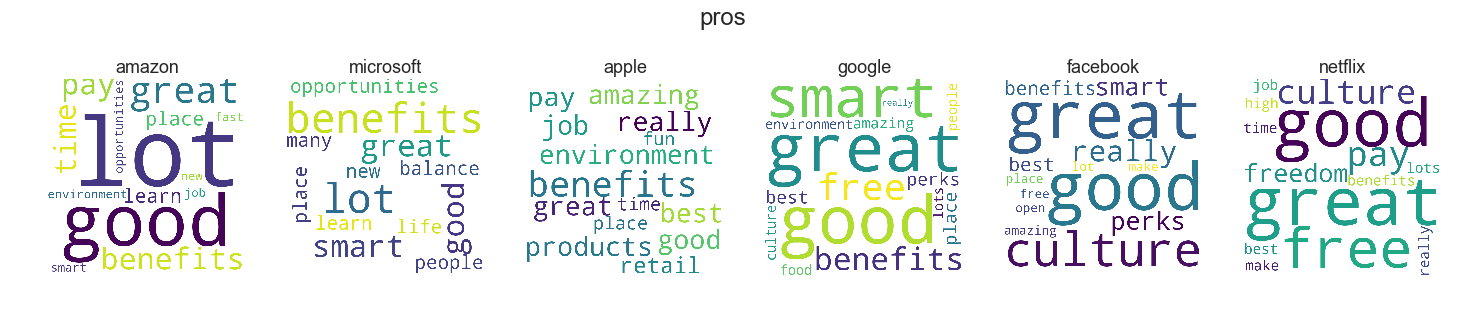

In [151]:
wordplot(15,"pros")

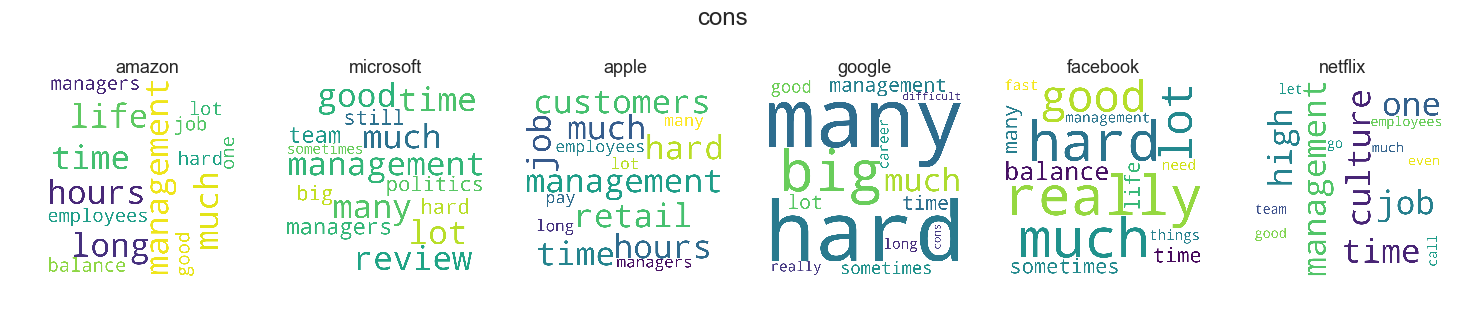

In [153]:
wordplot(15,"cons")

# Analysis by Location

After splitting up the data to figure out meaningful ways of extracting information from the set, we decided to figure out the average ratings for each category based on location. Location may play a factor in how employees rate their respective companies as a result of factors such as climate, nearby establishments, and the local population. We can’t exactly study these more nuanced factors so we will just look at overall ratings for each location. To begin, the columns that are irrelevant to this particular part were removed, such as the name of the company, comments, etc. Then, to process the remaining columns, the location and the ratings, I used an array of keys containing the names of each column so that I could organize their averages in respect to their location.

In [155]:
review_df = df[df['location'] != "none"]

In [158]:
# Nested values for average ratings for different ratings
review_dict = {}
inc = {}
keys = {'overall-ratings': 1, 'work-balance-stars': 1, 
       'culture-values-stars': 1, 'carrer-opportunities-stars': 1, 
       'comp-benefit-stars': 1, 'senior-mangemnet-stars': 1}

# Loop through all locations and calculate their average ratings
for index, row in review_df.iterrows():
    # location of current row
    location = row['location']
    
    # Put location in dictionarys
    if location not in review_dict:
        review_dict[location] = {}
        inc[location] = {}
        
    # Cycle through the keys for ratings
    for key in keys:
        # Check if value of column is valid
        if row[key] != 'none':
            # Check if location exists in dictionary currently
            if key in review_dict[location]:
                review_dict[location][key] += float(row[key])
                inc[location][key] += 1
            else:
                review_dict[location][key] = float(row[key])
                inc[location][key] = 1

In [162]:
# Loop through the dictionary to get the averages
for key in review_dict:
    for r_key in keys:
        if r_key in review_dict[key]:
            #print(review_dict[key][r_key])
            #print(inc[key][r_key])
            review_dict[key][r_key] = review_dict[key][r_key] / inc[key][r_key]
# Make dataframe from dictionary
average_review_df = pd.DataFrame.from_dict(review_dict, orient='index')
average_review_df.head()

,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars
"Aberdeen, MD",3.00,1.00,2.0,3.0,2.00,3.00
"Aberdeen, SD",5.00,NaN,NaN,NaN,NaN,NaN
"Aberdeen, Scotland (UK)",4.00,4.00,5.0,3.0,5.00,2.00
Abha (Saudi Arabia),5.00,4.00,NaN,5.0,3.00,4.00
Abidjan (Cote d'Ivoire),0.14,0.09,0.1,0.1,0.11,0.09


Based on the results, we found that each category of rating has multiple locations with the average rating of 5 out of 5. However, this could be skewed as there are varying numbers of reviews for companies in certain locations, with some locations only having one review. Therefore, these numbers are not definitive when used to draw a conclusion about the ratings. Additionally, every column has a rating of 5 at some location when you go down the list. Therefore, there are no real conclusions we can draw from this, except that some locations have high average ratings and some have low average ratings.

# Date and Count Based Ratings
The primary data columns extracted and used were the date, helpful review count, and different ratings, including overall. The weighting for both date and helpful review count were based off of several factors to limit the weight of one review overshadowing other reviews while maintaining a significantly higher weight in comparison to new reviews. In the end, the weight factor for helpful counts was set such that the highest review is 100, the minimum review (0) is 1, and everything in between is logarithmic; the weight factor for the dates is set such that a review from any year (e.g. 2018) is worth twice as much as the prior year (2017). The formula used for weighting the ratings is the following: helpful-count^((ln(100)/ln(maxCount))*0.5 ^(end year - current year)


In [176]:
"""
Iterate through the dataframe and find the weight.
Start year is 2008, end year is 2018.
Formula for years: 0.5 ^ (end year (2018) - current year)
Weight = log(helpful-count) w/ base ln(total reviews/votes)/ln(100) * 0.5 ^ (end year (2018) - current year)
"""
df = pd.read_csv("employee_reviews.csv")
maxYear = None
minYear = None
maxCount = 0
companyDictList = []
for i in range(4):
    companyDictList.append({})
companyNames = list(df['company'].value_counts().keys())
for compName in companyNames:
    for companyDict in companyDictList:
        companyDict[compName] = {'overall': 0, 'overall-weight': 0, \
                                 'work-life': 0, 'work-life-weight': 0, \
                                 'cultural-values': 0, 'cultural-values-weight': 0, \
                                 'career-growth': 0, 'career-growth-weight': 0, \
                                 'compensation': 0, 'compensation-weight': 0, \
                                 'management': 0, 'management-weight': 0}

for index, row in df.iterrows():
    if row['helpful-count'] > maxCount:
        maxCount = row['helpful-count']
    year = row['dates'][-4:]
    if year.isdigit():
        year = int(year)
        if maxYear == None: maxYear = year
        if year > maxYear:
            maxYear = year
        if minYear == None: minYear = year
        if year < minYear:
            minYear = year
yearDif = maxYear - minYear
factor = math.log(maxCount) / math.log(100)

# No weight for control (i = 0), weight for date only (i = 1), for count only (i = 2), for both (i = 3)
for index, row in df.iterrows():
    for i in range(len(companyDictList)):
        weight = 1
        if i % 2 == 1:
            if row['dates'][-4:].isdigit(): weight *= math.pow(0.5, maxYear - int(year))
            # assume year is start year (2008) if not provided
        if i > 1:
            weight *= math.pow(row['helpful-count'] + 1, 1 / factor)
        company = companyDictList[i][row['company']]
        if row['overall-ratings'] != 'none':
            company['overall'] += weight * float(row['overall-ratings'])
            company['overall-weight'] += weight
        if row['work-balance-stars'] != 'none':
            company['work-life'] += weight * float(row['work-balance-stars'])
            company['work-life-weight'] += weight
        if row['culture-values-stars'] != 'none':
            company['cultural-values'] += weight * float(row['culture-values-stars'])
            company['cultural-values-weight'] += weight
        if row['carrer-opportunities-stars'] != 'none':
            company['career-growth'] += weight * float(row['carrer-opportunities-stars'])
            company['career-growth-weight'] += weight
        if row['comp-benefit-stars'] != 'none':
            company['compensation'] += weight * float(row['comp-benefit-stars'])
            company['compensation-weight'] += weight
        if row['senior-mangemnet-stars'] != 'none':
            company['management'] += weight * float(row['senior-mangemnet-stars'])
            company['management-weight'] += weight

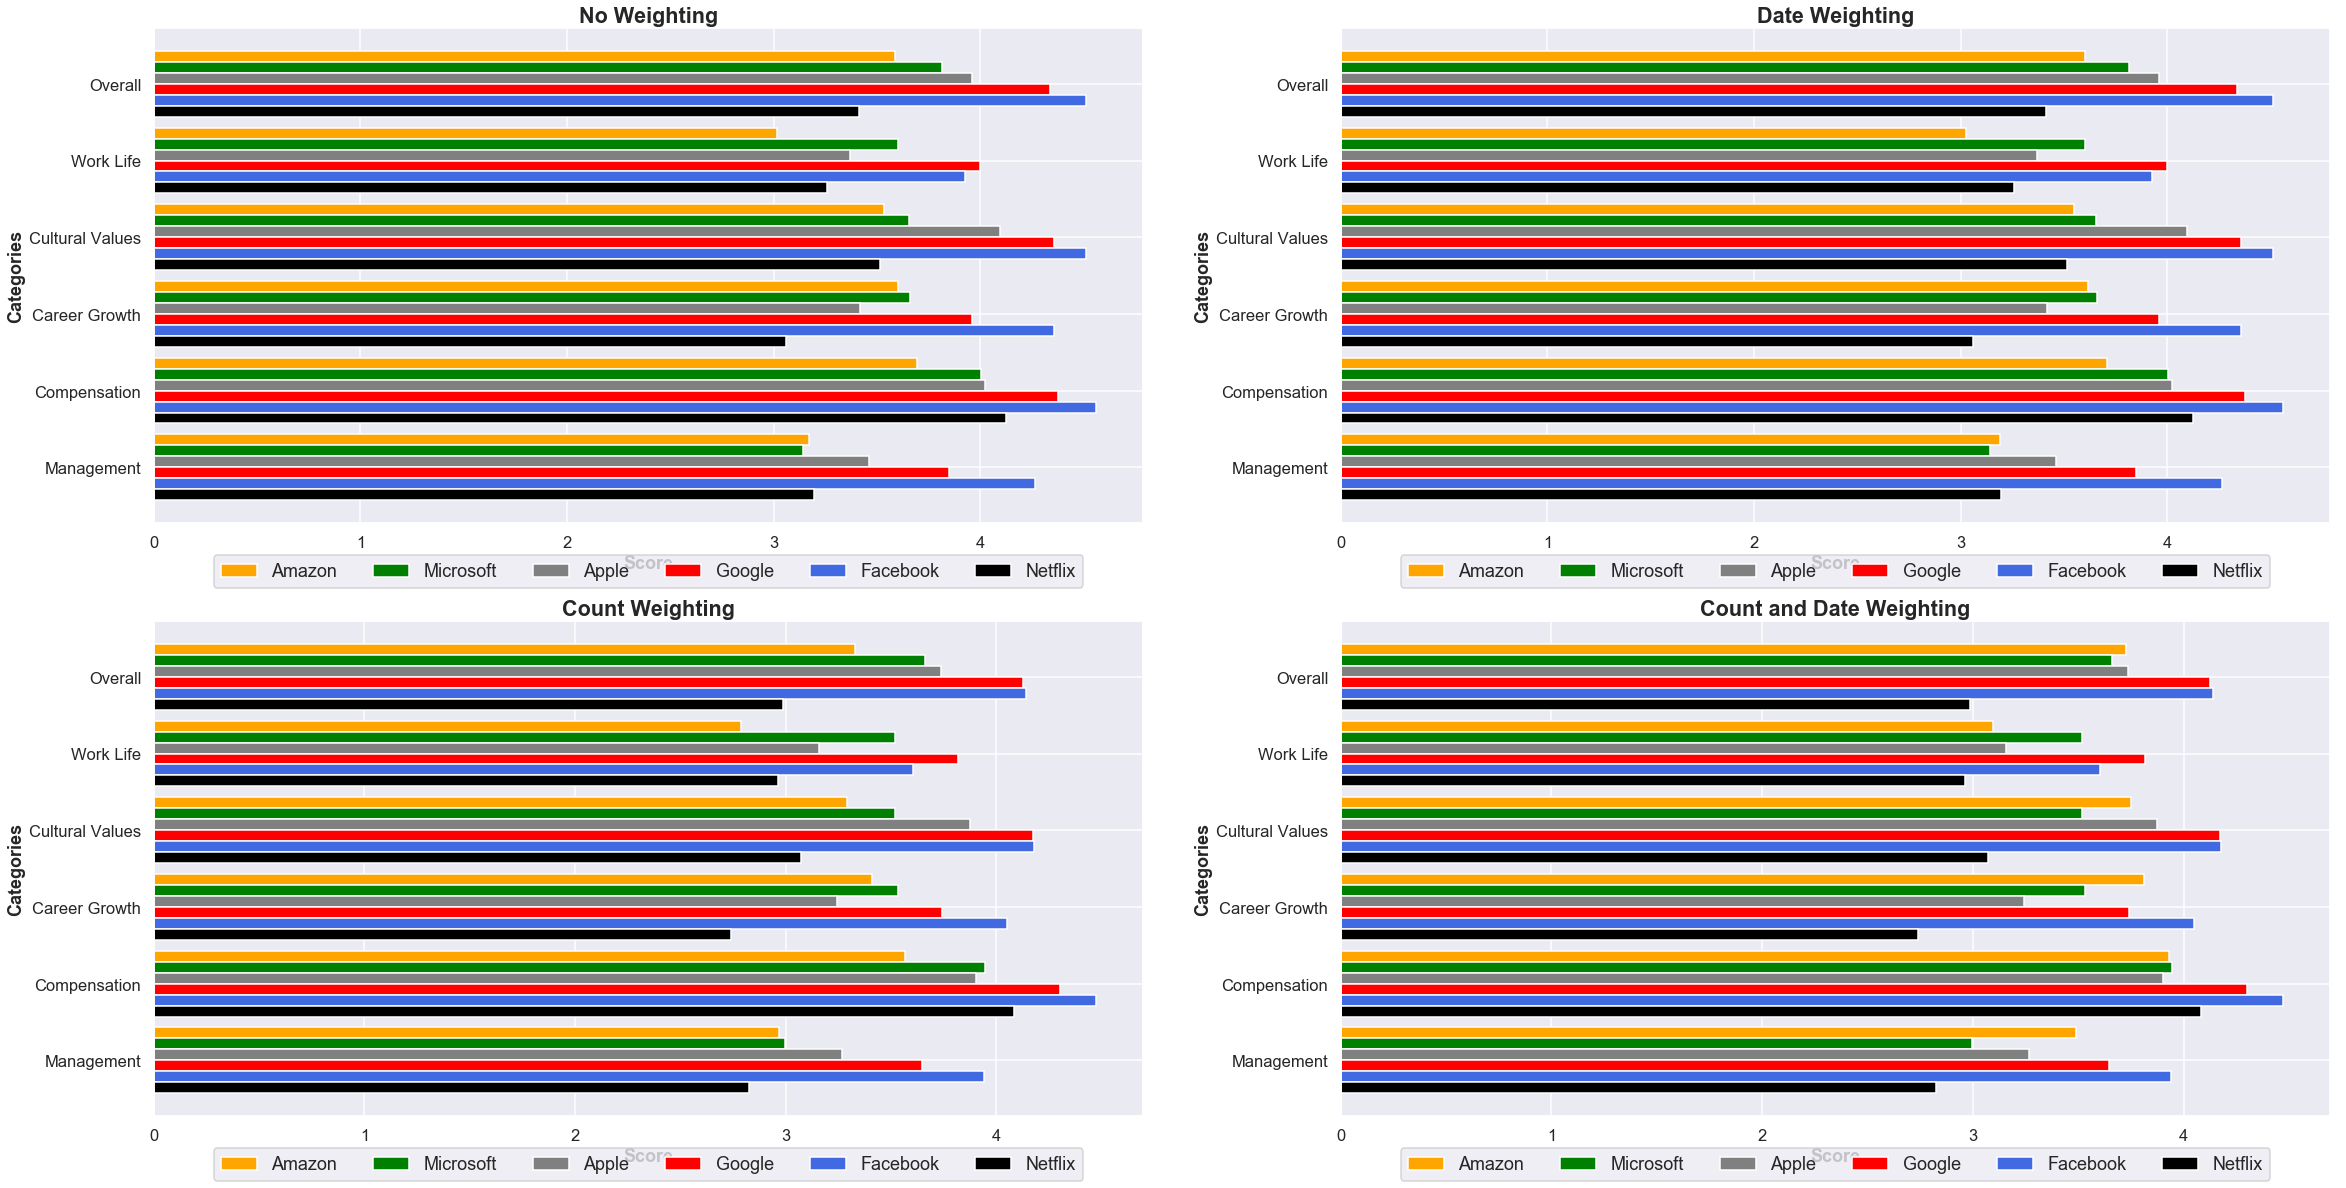

In [180]:
barWidth = 1.0 / (len(companyNames) + 1)
 
# set height of bar
for i in range(len(companyDictList)):
    barArray = []
    for k in range(len(companyNames)):
        barArray.append([])
    plt.subplot(int(math.sqrt(len(companyDictList))), int(math.sqrt(len(companyDictList))), i + 1)
    for j in range(len(companyNames)):
        company = companyDictList[i][companyNames[j]]
        barArray[j].append(company['overall'] / company['overall-weight'])
        barArray[j].append(company['work-life'] / company['work-life-weight'])
        barArray[j].append(company['cultural-values'] / company['cultural-values-weight'])
        barArray[j].append(company['career-growth'] / company['career-growth-weight'])
        barArray[j].append(company['compensation'] / company['compensation-weight'])
        barArray[j].append(company['management'] / company['management-weight'])
 
    # Set position of bar on X axis
    r1 = np.arange(len(barArray[0]))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    r5 = [x + barWidth for x in r4]
    r6 = [x + barWidth for x in r5]

    # Make the plot
    p1 = plt.barh(r1, barArray[0], color='orange', height=barWidth, edgecolor='white', label='Amazon')
    p2 = plt.barh(r2, barArray[1], color='green', height=barWidth, edgecolor='white', label='Microsoft')
    p3 = plt.barh(r3, barArray[2], color='gray', height=barWidth, edgecolor='white', label='Apple')
    p4 = plt.barh(r4, barArray[3], color='red', height=barWidth, edgecolor='white', label='Google')
    p5 = plt.barh(r5, barArray[4], color='royalblue', height=barWidth, edgecolor='white', label='Facebook')
    p6 = plt.barh(r6, barArray[5], color='black', height=barWidth, edgecolor='white', label='Netflix')
 
    # Add xticks on the middle of the group bars
    title = 'No Weighting'
    if i == 1:
        title = 'Date Weighting'
    if i == 2:
        title = 'Count Weighting'
    if i == 3:
        title = 'Count and Date Weighting'
    plt.title(title, fontsize='larger', fontweight='bold')
    plt.ylabel('Categories', fontsize='medium', fontweight='bold')
    plt.xlabel('Score', fontsize='medium', fontweight='bold')
    plt.yticks([r + (len(companyNames) - 1) / 2 * barWidth for r in range(len(barArray[0]))], ['Overall', 'Work Life', 'Cultural Values', 'Career Growth', 'Compensation', 'Management'])
    plt.gca().invert_yaxis()
    # Create legend & Show graphic
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), fontsize='medium', ncol = 6)
plt.rcParams['figure.figsize'] = [50,20]
plt.show()

After taking into consideration these factors, the unweighted summary tells a very different story: most of the ratings appear to be very high among all companies with Facebook leading the pack in every category, except work life, which belongs to Google. The count weighting shows lower scores across the board and reveals that satisfied employees tend to write more reviews whie dissatisfied employees tend to upvote lower score reviews. The date weighting doesn’t differ very much from the unweighted summary, which tells us that either the date weighting is too heavily skewed towards new reviews or that most reviews tend to be more recent; the former has been debunked and there are more recent reviews in the past few years than all other years combined. With both date and count weighting taken into consideration, scores move in either direction, but there are several notable changes: Amazon and Google having higher scores in almost every category, Apple and Microsoft remain constant, and Facebook and Netflix see a slight decrease; regardless, Facebook remains at the very top, with the exception of work-life balance at Google, even when accounting for these factors. One interesting takeaway is that compensation is the only category among all companies to have stayed the same or increased: this may explain the trend behind why jobs at these tech companies are highly coveted by applicants.

# Ethics and Privacy

Since all of the data is posted anonymously, most of the potential issues regarding the privacy of subjects are already addressed. The data we have does not include any information that would expose the identity of individuals we have collected data from. The most specific information we have regarding each individual is their location and company, which would not reveal much about the people in our dataset. In addition, Glassdoor is an application where people willingly post reviews regarding their employers. By posting a review, users agree to the “Glassdoor Terms of Use” such that they give Glassdoor “rights to your content” where Glassdoor is allowed “unrestricted, irrevocable, perpetual, non-exclusive, fully-paid and royalty-free, license (with the right to sublicense through unlimited levels of sublicenses) to use, copy, perform, display, create derivative works of, adapt and distribute” whatever information you give to them (https://www.glassdoor.com/about/terms.htm). For this reason, there is no violation of privacy because users are consciously posting this information publicly for other users. Since this data is posted publicly, there are also no legal issues with how this data is obtained since the data was gathered from a public website. 

However, one potential consequence of this study the effect on the companies being reviewed. Since this study will evaluate various aspects of each employer, from salary to working environment, it has the potential to result in a negative evaluation of the companies. This could potentially tarnish the reputation of the companies that we explored in this analysis. Given the power and voice of media in the present day, people are quick to criticize what they see, but what they might not see is how companies are handling these reviews offline to improve the negative aspects of their company. 

Source: https://www.forbes.com/sites/jaysondemers/2014/09/09/how-negative-online-company-reviews-can-impact-your-business-and-recruiting/#4fe9e8ee1d9b


# Conclusion and Discussion 


#### Limitations
We thought that having a discrete 5 star rating seemed a bit limiting because sometimes being able to give half a star more or less can give more information about how someone feels about a certain category. Having more features such as how long someone had/has worked for a company, when the helpful count vote was made, having non-anonymized job titles would have allowed us to perform more analysis on why people rate certain aspects of companies the way they did.

In conclusion, all the ratings of Netflix are lower than other companies across the board. However, we cannot be quick to draw conclusions about what is happening internally in the company and what they are doing to address these issues. Of the “pro” words, people liked the benefits, pay, and culture, and of the “con” words people disliked the management, difficulty of tasks, and the amount of time spent working. Our hypothesis was correct. By analyzing the positive and negative word count, we were able to draw better conclusions regarding each company since we could break down more specific pros for each company, rather than a discrete five-star rating on set categories.

With consideration to weighting, the main factors were the number of helpful ratings and the date the review was written. One thing that we noticed was that the helpful rating count weighting drops every company across the board; this meant that those who were satisfied tended to write their own reviews while those who were not satisfied with the company preferred to upvote other negative reviews. This led to a decrease in ratings for each company because the negative reviews were weighted heavier since they had more upvotes. For date weighting, it made little to no impact, which meant that most of the reviews were written recently. When both were taken into consideration, overall scores change across the board as Amazon overtakes Microsoft and ties with Apple while Netflix drops a significant margin and Google ties with Facebook for first place. Overall, Amazon is improving by a wide margin in most categories aside from Work Life; Apple  and Microsoft remain roughly the same as they were before; Google had a slight dip in Career Growth and Management, but remains a top pick among the companies listed; Facebook has dropped across the board, but holds the title for best Compensation; Netflix has a significant drop across all categories, except for compensation. Overall, Facebook appears to be the winner in every category aside from the Work Life category, which is held by Google; however, either Amazon or Google could overtake Facebook in the near future.

